In [1]:
%matplotlib inline
import datetime
import calendar
from pandas import DataFrame,Series
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime

# Get stock data

In [2]:
stock_data = pd.read_csv("000001ss-2015-1-1-2017-3-1.csv",index_col=0,parse_dates=True,usecols = ["Date","Adj Close"],dtype={"Adj Close":np.float64})

## Preview of stock data

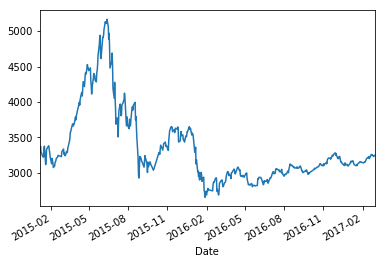

In [3]:
stock_data["Adj Close"].plot()

# Get 资产配置 (Asset Allocation) (ZCPZ ) data
only analyze "hybrid fund", because this is the most flexible fund

In [4]:
conn = sqlite3.connect(r'../crawler/FundProject.db')
all_fund_info = pd.read_sql("SELECT * FROM FundBasicInfo",conn,parse_dates=['fund_start_date'])
print(len(all_fund_info.index))

4881


In [5]:
fund_zcpz = DataFrame(columns=['fund_id','date','stock_percent','bond_percent','currency_percent','net_asset'])
for index in all_fund_info.index:
    if all_fund_info.loc[index,'fund_cate'] == '混合型':
        query_sql = "SELECT * FROM zcpz_tbl WHERE fund_id = '{0}'".format( all_fund_info.loc[index,'fund_id'] )
#         print(query_sql)
        temp_zcpz = pd.read_sql(query_sql,conn,parse_dates=['date'])
        fund_zcpz = pd.concat([fund_zcpz,temp_zcpz],axis=0)

In [6]:
# index of fund_zcpz is not unique, fix it
fund_zcpz.index = range(len(fund_zcpz.index))

In [7]:
# preview of data
fund_zcpz.head()

,fund_id,date,stock_percent,bond_percent,currency_percent,net_asset
0,100056,2011-12-31,72.31,0,26.96,6.45
1,100056,2012-03-31,94.21,0,6.62,5.80
2,100056,2012-06-30,93.32,0,7.11,5.59
3,100056,2012-09-30,88.74,--,11.68,5.05
4,100056,2012-12-31,93.01,--,5.35,5.32


## Translate Date  to quarter

In [8]:
#create mapping between date and quarter name
# date_to_quarter = DataFrame({'quarter_name':['Q1','Q2','Q3','Q4'],'month':[3,6,9,12],'start_day':[1,1,1,1],'end_day':[31,30,30,12]})
date_to_quarter = DataFrame({'quarter_name':['Q1','Q2','Q3','Q4'],'month':[3,6,9,12]})

In [9]:
date_to_quarter

,month,quarter_name
0,3,Q1
1,6,Q2
2,9,Q3
3,12,Q4


In [10]:
# add a quarter column to fund_zcpz table 

for index in fund_zcpz.index:
    date = fund_zcpz.loc[index,'date']
    for quarter_index in date_to_quarter.index:
        if date.month == date_to_quarter.loc[quarter_index,'month']:
            fund_zcpz.loc[index,'quarter'] = str(date.year)+date_to_quarter.loc[quarter_index,'quarter_name']
            break

In [11]:
#preview date
fund_zcpz.head()

,fund_id,date,stock_percent,bond_percent,currency_percent,net_asset,quarter
0,100056,2011-12-31,72.31,0,26.96,6.45,2011Q4
1,100056,2012-03-31,94.21,0,6.62,5.80,2012Q1
2,100056,2012-06-30,93.32,0,7.11,5.59,2012Q2
3,100056,2012-09-30,88.74,--,11.68,5.05,2012Q3
4,100056,2012-12-31,93.01,--,5.35,5.32,2012Q4


In [12]:
fund_zcpz.tail()

,fund_id,date,stock_percent,bond_percent,currency_percent,net_asset,quarter
26554,002803,2017-03-31,80.68,--,19.7,32.55,2017Q1
26555,002410,2016-06-30,3.62,88.1,0.4,6.04,2016Q2
26556,002410,2016-09-30,8.51,96.53,1,6.26,2016Q3
26557,002410,2016-12-31,8.29,100.16,2.03,6.13,2016Q4
26558,002410,2017-03-31,9.35,92.33,7.94,2.14,2017Q1


## Fix some data is "--"

In [13]:
fund_zcpz.replace('--',0,inplace=True)
fund_zcpz.head()

,fund_id,date,stock_percent,bond_percent,currency_percent,net_asset,quarter
0,100056,2011-12-31,72.31,0.0,26.96,6.45,2011Q4
1,100056,2012-03-31,94.21,0.0,6.62,5.80,2012Q1
2,100056,2012-06-30,93.32,0.0,7.11,5.59,2012Q2
3,100056,2012-09-30,88.74,0.0,11.68,5.05,2012Q3
4,100056,2012-12-31,93.01,0.0,5.35,5.32,2012Q4


## type of stock bond, currency , net_asset is string, not float 

In [14]:
fund_zcpz[['stock_percent','bond_percent','currency_percent','net_asset']].astype(np.float32)
fund_zcpz.dtypes

fund_id                     object
date                datetime64[ns]
stock_percent              float64
bond_percent               float64
currency_percent           float64
net_asset                  float64
quarter                     object
dtype: object

## Calculate mean value of ZCPZ

In [15]:
fund_zcpz_mean_by_quarter = fund_zcpz.groupby('quarter').mean()

In [16]:
fund_zcpz_mean_by_quarter

,stock_percent,bond_percent,currency_percent,net_asset
quarter,,,,
2001Q4,21.890000,0.000000,0.000000,42.825000
2002Q1,30.793333,0.393333,0.000000,38.140000
2002Q2,48.003333,1.923333,0.000000,39.926667
2002Q3,54.668000,2.972000,0.000000,37.534000
2002Q4,44.807273,8.486364,1.036364,28.978182
2003Q1,50.890000,11.572857,1.291429,25.459286
2003Q2,49.509000,13.326500,2.094000,17.580500
2003Q3,51.475769,11.819615,1.828077,15.101154
2003Q4,64.324118,10.538235,1.760588,14.328235


### Focus on 2015

In [17]:
fund_zcpz_mean_by_quarter_2015 = fund_zcpz_mean_by_quarter.loc[['2015Q1','2015Q2','2015Q3','2015Q4'],:]

In [18]:
fund_zcpz_mean_by_quarter_2015

,stock_percent,bond_percent,currency_percent,net_asset
quarter,,,,
2015Q1,76.900818,7.852296,12.380739,21.721781
2015Q2,68.713030,7.063462,22.798166,29.105786
2015Q3,51.440461,22.620768,22.830795,16.016829
2015Q4,55.453875,15.579975,18.925730,19.841138


In [19]:
pre_index = None
for index in fund_zcpz_mean_by_quarter_2015.index:
    if not pre_index:
        fund_zcpz_mean_by_quarter_2015.loc[index,'diff_stock(%)'] = 0
        pre_index = index
        continue
    fund_zcpz_mean_by_quarter_2015.loc[index,'diff_stock(%)'] = ((fund_zcpz_mean_by_quarter_2015.loc[index,'stock_percent'] - fund_zcpz_mean_by_quarter_2015.loc[pre_index,'stock_percent'])/fund_zcpz_mean_by_quarter_2015.loc[pre_index,'stock_percent'])*100
    pre_index = index
    

In [20]:
fund_zcpz_mean_by_quarter_2015

,stock_percent,bond_percent,currency_percent,net_asset,diff_stock(%)
quarter,,,,,
2015Q1,76.900818,7.852296,12.380739,21.721781,0.000000
2015Q2,68.713030,7.063462,22.798166,29.105786,-10.647206
2015Q3,51.440461,22.620768,22.830795,16.016829,-25.137254
2015Q4,55.453875,15.579975,18.925730,19.841138,7.802057


* stock percent of asset is at highest point at 2015 Q1.
* Q2 is lower than Q1 by 10.6%
* Q3 is lower than Q2 by 25.7%

**more money is invested into sockmarket when stock index is rising, the highest point ot stock index is at Q2, some stock is start decrease stock percent before stock market crash.**

Find out these funds

## Find out Funds that decrease stock share before stock market crash

### Calculate difference between 2015Q1 and 2015Q2

In [21]:
# filter all fund zcpz data to 2015Q1 2015Q2
fund_zcpz_2015_Q1Q2 = fund_zcpz[ (fund_zcpz['quarter']=='2015Q1') | (fund_zcpz['quarter']=='2015Q2')]

In [22]:
fund_zcpz_2015_Q1Q2 = fund_zcpz_2015_Q1Q2.sort_values(['fund_id','quarter'])
fund_zcpz_2015_Q1Q2.head()

,fund_id,date,stock_percent,bond_percent,currency_percent,net_asset,quarter
17574,000001,2015-03-31,77.52,20.34,4.80,91.84,2015Q1
17575,000001,2015-06-30,71.15,24.81,10.09,78.66,2015Q2
22465,000011,2015-03-31,91.25,3.49,7.76,25.79,2015Q1
22466,000011,2015-06-30,79.60,1.89,24.81,21.17,2015Q2
20917,000017,2015-03-31,93.40,0.00,10.23,6.40,2015Q1


In [23]:
fund_zcpz_2015_Q1Q2[fund_zcpz_2015_Q1Q2['fund_id']=="673010"]

,fund_id,date,stock_percent,bond_percent,currency_percent,net_asset,quarter
22178,673010,2015-03-31,2.05,0.0,98.08,4.62,2015Q1
22179,673010,2015-06-30,80.28,0.0,27.37,0.25,2015Q2


In [24]:
def calculate_stock_diff(group_zcpz):
    t_1 = -1
    for i in group_zcpz['stock_percent'].index:
        if t_1 == -1:
            t_1 = group_zcpz['stock_percent'][i]
            continue
        return 100*( (group_zcpz['stock_percent'][i] - t_1)/t_1 )
    return -1

In [25]:
fund_zcpz_2015_Q1Q2_by_id = fund_zcpz_2015_Q1Q2.groupby(['fund_id']).apply(calculate_stock_diff)

/home/scott/anaconda3/envs/fundanalysis/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/home/scott/anaconda3/envs/fundanalysis/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [26]:
fund_zcpz_2015_Q1Q2_by_id = fund_zcpz_2015_Q1Q2_by_id.sort_values(ascending=True)

### all the funds that decrease stock percent at least 30%, good!

In [27]:
fund_zcpz_2015_Q1Q2_by_id[fund_zcpz_2015_Q1Q2_by_id<-30]

fund_id
519183   -99.358274
080008   -99.268922
519156   -99.194048
519130   -99.188245
000063   -99.015550
000663   -98.336311
519120   -98.188102
164205   -97.923255
519127   -97.775031
000932   -97.392638
000933   -97.392638
000739   -96.821983
000496   -95.934959
762001   -95.826137
000410   -94.129074
000273   -93.302805
000597   -92.987805
000585   -92.046287
000508   -87.248322
000507   -87.248322
000125   -86.833333
166020   -86.748216
000531   -85.945946
000590   -85.348837
210010   -83.368421
210011   -83.368421
000121   -82.867133
200001   -80.494505
519050   -79.665072
000538   -79.421222
            ...    
519971   -65.120968
000433   -64.969450
000796   -64.532082
000794   -64.532082
487021   -53.396226
210001   -52.419672
233008   -50.546720
000571   -50.237559
540001   -49.232013
000556   -48.453608
000557   -48.453608
000887   -48.088023
750005   -47.328244
000431   -44.303797
000215   -43.795620
350007   -43.531469
393001   -42.904489
400023   -41.885965
000763   -38

### all the funds that increase stock percent at least 30%, !!!

In [28]:
fund_zcpz_2015_Q1Q2_by_id[fund_zcpz_2015_Q1Q2_by_id>30]

fund_id
000904      31.587079
160812      32.252739
000512      32.926829
000894      35.145784
180020      36.557581
000199      37.648398
400007      40.374453
398041      40.820896
000639      41.438849
000714      44.666667
000844      46.453546
090016      46.672255
090020      47.912018
000679      70.982143
166801      78.885400
000664      87.012987
000065      88.023952
730002      91.374714
000865     105.813953
000511     115.094340
000436     122.727273
000886     152.406903
001007     154.385965
000672     160.869565
000667     160.869565
519020     210.389610
519191     220.000000
000573     280.000000
000214     323.076923
740001    1130.188679
673010    3816.097561
290012            inf
dtype: float64

# Next, fund out if there is a relationship between them

ideas: fund company , fund manager, so on!